In [97]:
import pandas as pd
import numpy as np
import sys
import os
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from openpyxl.worksheet.formula import ArrayFormula
from openpyxl import Workbook
from openpyxl.styles import Alignment
import re

import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import statsmodels.formula.api as smf

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import IPython.display
from IPython.display import display, clear_output

SURVEY_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\base'
CENSUS_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\census'
ASIM_OUTPUT = r'E:\Met_Council\metc-asim-model\Base_2022\activitysim\output'
TAZ_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\SHP'

# Set to None if estimation is not being used
ESTIMATION_LOG_PATH = r'E:\Met_Council\metc-asim-model\estimation\output\work_loc_estimation\destination_choice\work_location_choice\Run 65'

survey_tlfd = pd.read_csv(os.path.join(SURVEY_SUMMARY_PATH, 'workTLFD.csv'))

taz = gpd.read_file(os.path.join(TAZ_PATH, "TAZ2010.shp")).set_index("TAZ")

hh = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_households.csv"))
hh['auto_suff'] = 2
hh.loc[hh['auto_ownership'] >= hh['num_workers'], 'auto_suff'] = 3
hh.loc[hh['auto_ownership'] == 0, 'auto_suff'] = 1

persons = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_persons.csv"))
persons['distbin'] = np.maximum(1, np.minimum(np.round(persons.distance_to_work), 51))
persons['distx'] = np.minimum(np.round(persons.distance_to_work), 51)
persons = persons.merge(taz['CO_NAME'], how = 'left', left_on = 'workplace_zone_id', right_index = True).rename(columns = {'CO_NAME': 'work_county'})

persons = persons.merge(hh[['household_id', 'auto_suff']], how = 'left', on = 'household_id')

counties = survey_tlfd.columns[1:]

co_state = {'Anoka': 'MN', 'Carver': 'MN', 'Chisago': 'MN', 'Dakota': 'MN', 'Goodhue': 'MN', 'Hennepin': 'MN', 'Isanti': 'MN', 'Le Sueur': 'MN', 
    'McLeod': 'MN', 'Pierce': 'WI', 'Polk': 'WI', 'Ramsey': 'MN', 'Rice': 'MN', 'Scott': 'MN', 'Sherburne': 'MN', 'Sibley': 'MN', 'St. Croix': 'WI', 
    'Washington': 'MN', 'Wright': 'MN'}

mc_counties = ['Anoka', 'Dakota', 'Carver', 'Hennepin', 'Ramsey', 'Scott', 'Washington']


# Regional Distance to Work

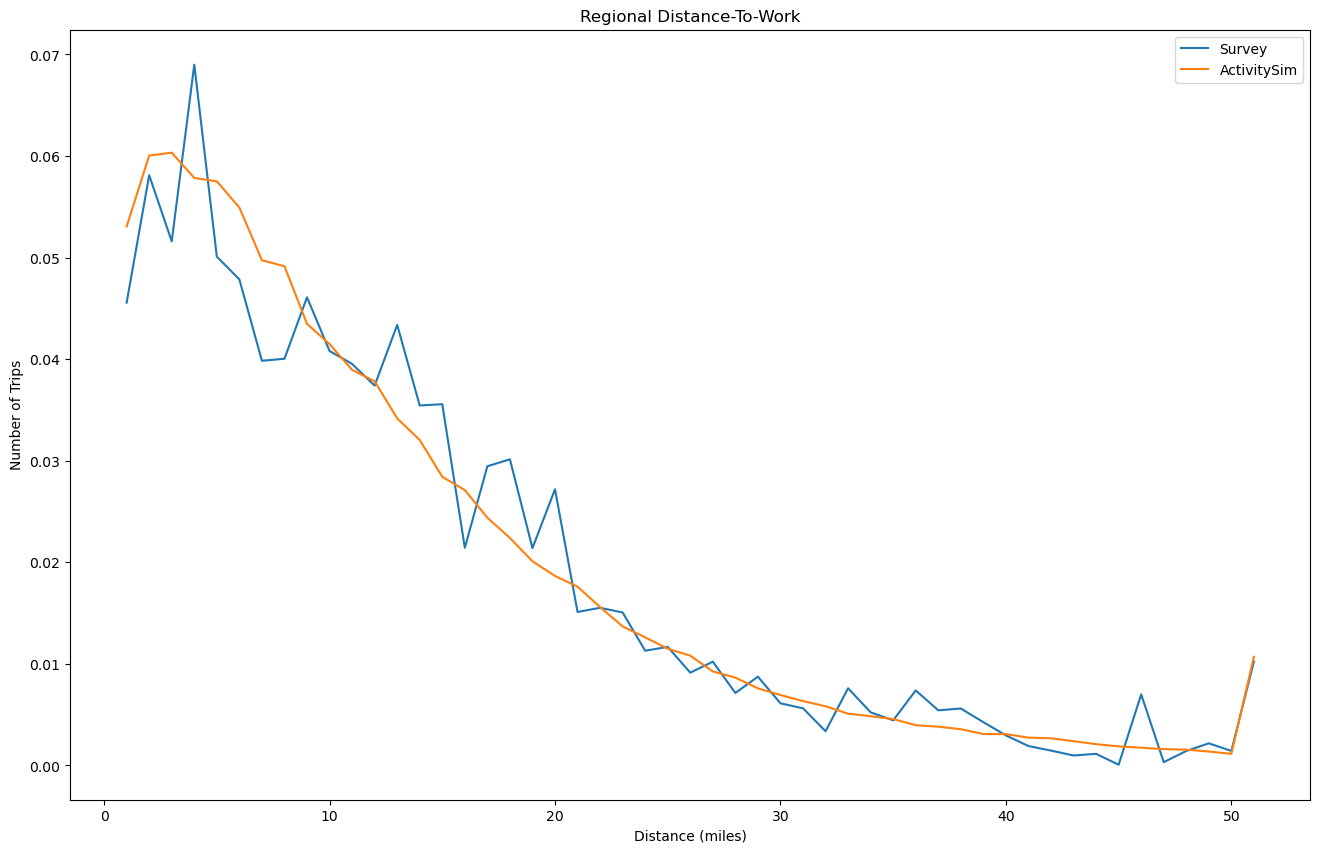

In [98]:
def tlf_chart(county):
    if county == 'Total':
        plot_title = 'Regional Distance-To-Work'
        model_summary = persons[persons['is_out_of_home_worker']].groupby('distbin').agg(model = ('person_id', 'count')) / persons[persons['is_out_of_home_worker']].shape[0]
    else:
        plot_title = f'Distance-To-Work for {county}'
        model_summary = persons[(persons['home_county'] == county) & (persons['is_worker'])].groupby('distbin').agg(model = ('person_id', 'count')) / persons[(persons['home_county'] == county) & (persons['is_worker'])].shape[0] 
    plot_data = survey_tlfd[['distbin', county]].copy()
    plot_data['survey'] = plot_data[county] / plot_data[county].sum()
    plot_data = plot_data[['distbin', 'survey']].merge(model_summary[['model']], how = 'outer', left_on = 'distbin', right_index = True).fillna(0)
    fig = plt.figure(figsize=(16,10))
    ax = fig.add_subplot()
    ax.plot(plot_data.distbin, plot_data.survey, label = 'Survey')
    ax.plot(plot_data.distbin, plot_data.model, label = 'ActivitySim')
    plt.legend(loc='upper right')
    plt.title(plot_title)
    ax.set_xlabel('Distance (miles)')
    ax.set_ylabel('Number of Trips')

tlf_chart('Total')

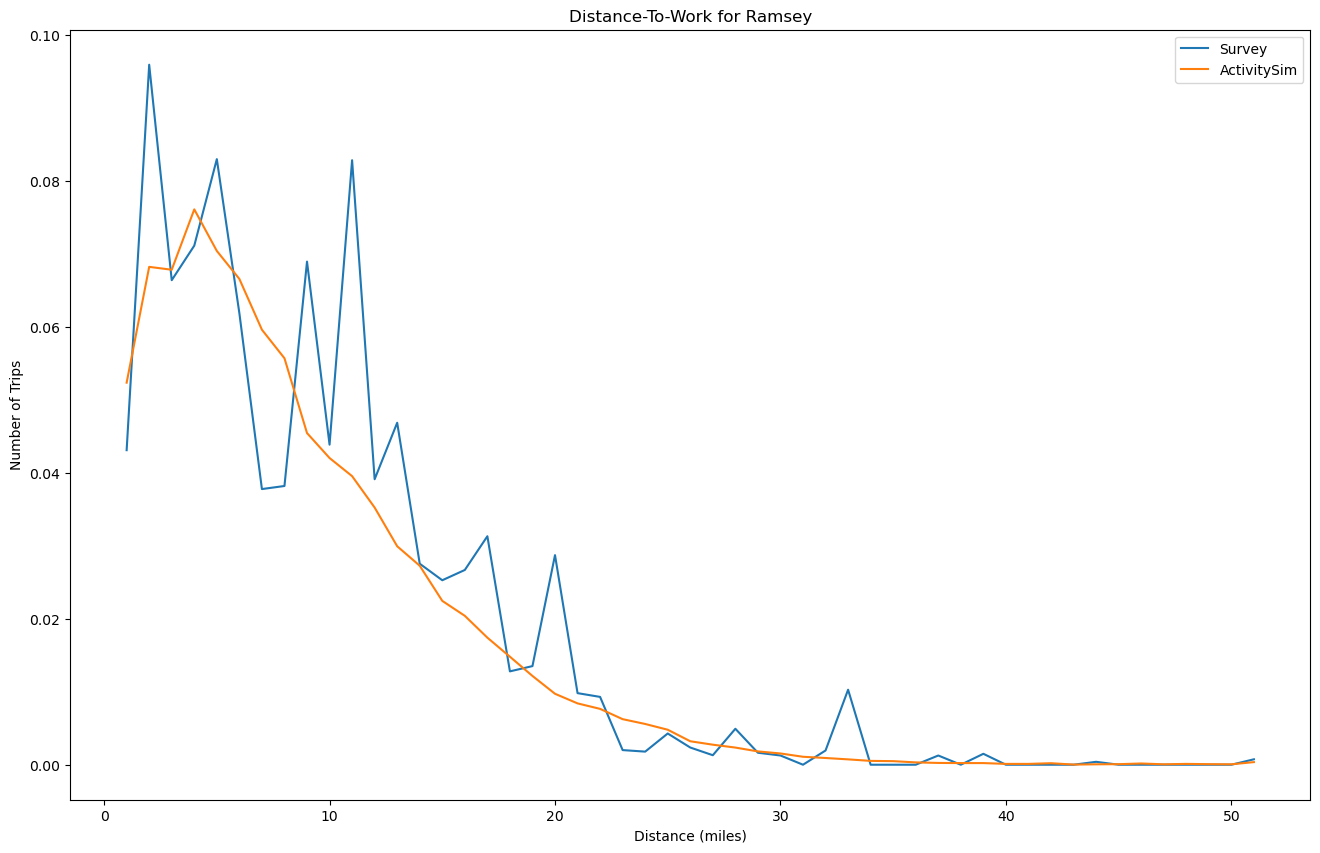

In [99]:
def dropdown_menu_widget_county_tlf():
    output = widgets.Output()

    dropdown_county = widgets.Dropdown(options = counties, value = None, description = 'County:')
    
    def dropdown_county_event_handler(change):
        display(input_widgets)
        state_choice = change.new
        tlf_chart(dropdown_county.value)
        IPython.display.clear_output(wait=True)  
        display(input_widgets)

    dropdown_county.observe(dropdown_county_event_handler, names='value')
    

    input_widgets = widgets.HBox([dropdown_county])
    
    display(input_widgets)
    IPython.display.clear_output(wait=True)   

dropdown_menu_widget_county_tlf()
        

# Zero Auto

Text(0, 0.5, 'Number of Trips')

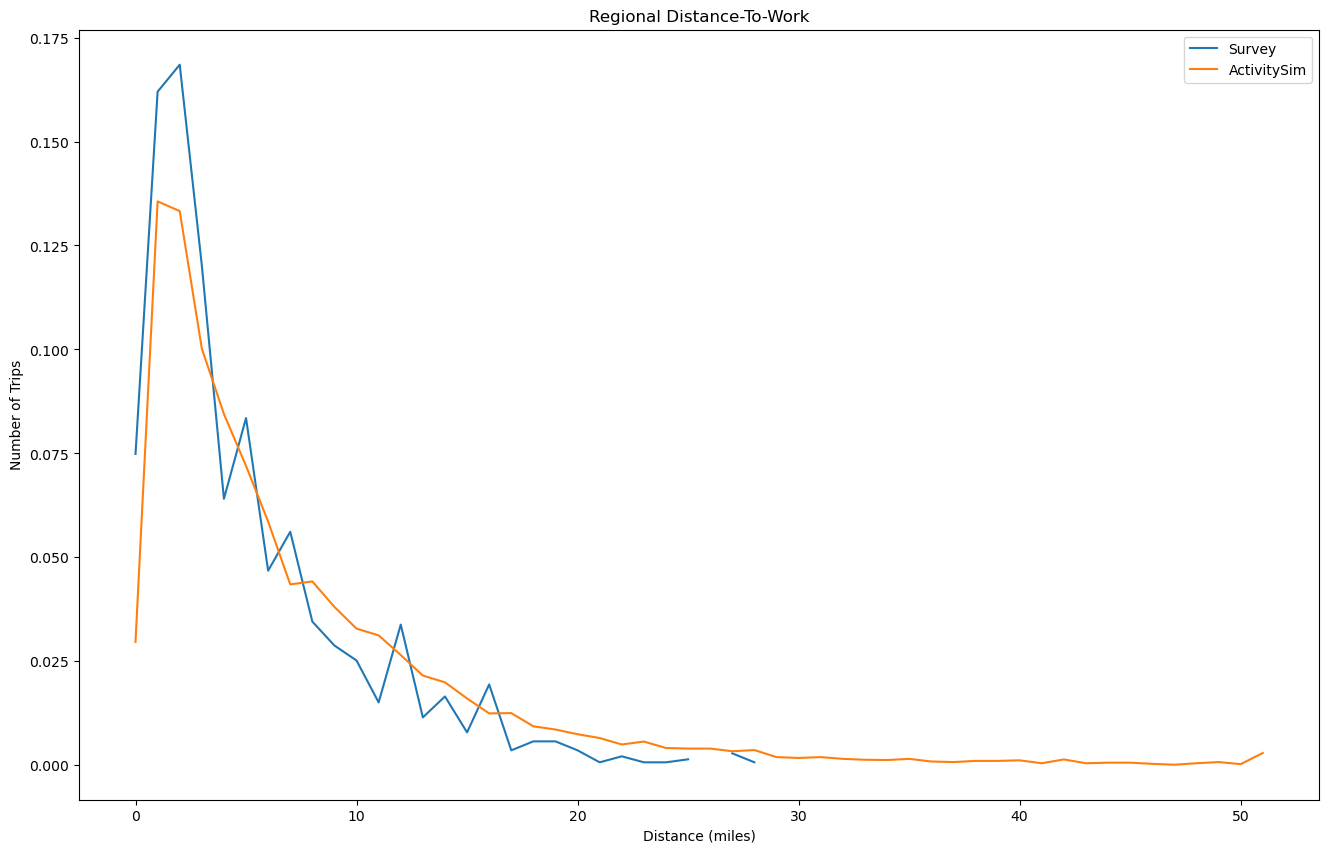

In [100]:
obs_by_as = pd.read_csv(r'support\tlf_as.csv')

plot_title = 'Regional Distance-To-Work'
model_summary = (persons[persons['is_out_of_home_worker']].groupby(['auto_suff', 'distx']).agg(model = ('person_id', 'count')) / persons[persons['is_out_of_home_worker']].groupby('auto_suff').agg(model = ('person_id', 'count'))).reset_index()

plot_data = model_summary.merge(obs_by_as, how = 'left', on = ['auto_suff', 'distx'])
plot_data = plot_data[plot_data['auto_suff'] == 1]
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot()
ax.plot(plot_data.distx, plot_data.pct_workers, label = 'Survey')
ax.plot(plot_data.distx, plot_data.model, label = 'ActivitySim')
plt.legend(loc='upper right')
plt.title(plot_title)
ax.set_xlabel('Distance (miles)')
ax.set_ylabel('Number of Trips')

In [101]:
persons.home_county.value_counts()

Hennepin      247128
Ramsey        103003
Dakota         85418
Anoka          71840
Washington     52205
Scott          29574
Wright         29060
Carver         20918
Sherburne      19118
St. Croix      18479
Rice           11957
Chisago        11301
Goodhue         9416
Polk            8623
Isanti          8286
Pierce          7945
McLeod          7282
Le Sueur        5714
Sibley          2883
Name: home_county, dtype: int64

# Average Trip Length

In [102]:
model_atl = persons[persons['is_out_of_home_worker']].groupby(['home_county']).agg(model = ('distance_to_work', 'mean')).reset_index().rename(columns = {'home_county': 'District'})
model_atl.loc[model_atl.shape[0]] = {'District': 'Total', 'model': persons[persons['is_out_of_home_worker']].distance_to_work.mean()}
obs_mand_tour_len = pd.read_csv(os.path.join(SURVEY_SUMMARY_PATH, "mandTourLengths.csv"))

obs_mand_tour_len[['District', 'Work']].rename(columns = {'Work': 'Observed'}).merge(model_atl, how = 'left', on = 'District')

,District,Observed,model
0,Anoka,14.401295,14.561857
1,Carver,21.368857,16.042654
2,Chisago,25.811136,23.265777
3,Dakota,12.833870,12.335982
4,Goodhue,22.463179,17.554287
5,Hennepin,9.080967,9.045116
6,Isanti,21.124780,24.429323
7,Le Sueur,22.800204,24.545267
8,McLeod,6.540910,13.765379
9,Pierce,14.170825,20.084692


In [103]:
obs_mand_tour_len[obs_mand_tour_len['District'].isin(mc_counties)][['District', 'Work']].rename(columns = {'Work': 'Observed'}).merge(model_atl, how = 'left', on = 'District')

,District,Observed,model
0,Anoka,14.401295,14.561857
1,Carver,21.368857,16.042654
2,Dakota,12.833870,12.335982
3,Hennepin,9.080967,9.045116
4,Ramsey,8.889976,8.715766
5,Scott,13.121395,15.420513
6,Washington,12.471665,14.499085


# Excel Output

In [104]:
#NOTE: The countyFlowsCensus file is 
model_co_flow_1 = persons[persons['is_out_of_home_worker']].groupby(['home_county', 'work_county']).agg(model_workers = ('person_id', 'count')).reset_index().pivot(index = 'home_county', columns = 'work_county', values = 'model_workers').fillna(0)
census_co_flow = pd.read_csv(os.path.join(CENSUS_SUMMARY_PATH, 'countyFlowsCensus2021.csv'), index_col = 0)
census_co_flow['home_state'] = census_co_flow.index.map(co_state)
census_co_flow.loc['work_state'] = census_co_flow.columns.map(co_state)


In [105]:

EXP_FAC = np.nan_to_num(census_co_flow['Total']['Total'], 0) / model_co_flow_1.sum().sum()
model_co_flow = model_co_flow_1 * EXP_FAC
model_co_flow['Total'] = model_co_flow.sum(1)
model_co_flow.loc['Total'] = model_co_flow.sum(0)
model_co_flow['home_state'] = model_co_flow.index.map(co_state)
model_co_flow.loc['work_state'] = model_co_flow.columns.map(co_state)

print(f'Adjusting the model by {EXP_FAC:0.4f}')

Adjusting the model by 4.4928


In [106]:
def write_state_compare_sheet(worksheet):
    row_num = 4
    col_num = 1

    worksheet.merge_cells(start_row=2, start_column=1, end_row=2, end_column=3)
    worksheet.cell(2, 1, "Census").alignment = Alignment(horizontal='center', vertical='center')
    worksheet.cell(3, 2, "MN")
    worksheet.cell(3, 3, "WI")
    worksheet.cell(4, 1, "MN")
    worksheet.cell(5, 1, "WI")
    worksheet["B4"] = ArrayFormula("B4","=SUM(IF(A4=Census!V2:V21,IF(B3=Census!B22:U22,Census!B2:U21,0),0))")
    worksheet["C4"] = ArrayFormula("C4","=SUM(IF(A4=Census!V2:V21,IF(C3=Census!B22:U22,Census!B2:U21,0),0))") #.number_format = "#,##0"
    worksheet["B5"] = ArrayFormula("B5","=SUM(IF(A5=Census!V2:V21,IF(B3=Census!B22:U22,Census!B2:U21,0),0))") #.number_format = "#,##0"
    worksheet["C5"] = ArrayFormula("C5","=SUM(IF(A5=Census!V2:V21,IF(C3=Census!B22:U22,Census!B2:U21,0),0))") #.number_format = "#,##0"
    
    
    worksheet.merge_cells(start_row=7, start_column=1, end_row=7, end_column=3)
    worksheet.cell(7, 1, "Model").alignment = Alignment(horizontal='center', vertical='center')
    worksheet.cell(8, 2, "MN")
    worksheet.cell(8, 3, "WI")
    worksheet.cell(9, 1, "MN")
    worksheet.cell(10, 1, "WI")
    worksheet["B9"] = ArrayFormula("B9","=SUM(IF(A9=Model!V2:V21,IF(B8=Model!B22:U22,Model!B2:U21,0),0))") #.number_format = "#,##0"
    worksheet["C9"] = ArrayFormula("C9","=SUM(IF(A9=Model!V2:V21,IF(C8=Model!B22:U22,Model!B2:U21,0),0))") #.number_format = "#,##0"
    worksheet["B10"] = ArrayFormula("B10","=SUM(IF(A10=Model!V2:V21,IF(B8=Model!B22:U22,Model!B2:U21,0),0))") #.number_format = "#,##0"
    worksheet["C10"] = ArrayFormula("C10","=SUM(IF(A10=Model!V2:V21,IF(C8=Model!B22:U22,Model!B2:U21,0),0))") #.number_format = "#,##0"
    
    for c in ['B', 'C']:
        for r in [4, 5, 9, 10]:
            worksheet[f'{c}{r}'].number_format = "#,##0"

    

def fix_format(worksheet):
    for c in range(66, 86):
        for r in range(2, 22):
            worksheet[f'{chr(c)}{r}'].number_format = "#,##0"

# with pd.ExcelWriter(r'spreadsheets\work_county_flow.xlsx', engine='openpyxl') as e:
#     model_co_flow.to_excel(e, "Model")
#     census_co_flow.to_excel(e, "Census")
#     pd.DataFrame().to_excel(e, "StateComp")
#     write_state_compare_sheet(e.sheets['StateComp'])
#     fix_format(e.sheets['Model'])
#     fix_format(e.sheets['Census'])

In [107]:
def fix_formats(worksheet, num_rows):
    for (c, w) in zip(['A', 'B', 'C', 'D', 'E', 'F'], [12, 35, 10, 12, 12, 12]):
        worksheet.column_dimensions[c].width = w
    for r in range(1, num_rows):
        for c in ['D', 'E', 'F']:
            worksheet[f'{c}{r}'].number_format = "0.0000"

def write_est_log(ws):
    ws["A1"] = "N Observations"
    ws['B1'] = alogit_obs
    ws['B1'].number_format = "#,##0"
    ws['A2'] = "N Iterations"
    ws['B2'] = alogit_iter
    ws['B2'].number_format = "#,##0"
    ws['A3'] = "Initial LL"
    ws['B3'] = log_like_init
    ws['B3'].number_format = "#,##0.00"
    ws['A4'] = "LL w.r.t. 0"
    ws['B4'] = log_like_wrt_zero
    ws['B4'].number_format = "#,##0.00"
    ws['A5'] = "LL w.r.t. constants"
    ws['B5'] = log_like_wrt_constants
    ws['B5'].number_format = "#,##0.00"
    ws['A6'] = "Final LL"
    ws['B6'] = log_like_final
    ws['B6'].number_format = "#,##0.00"
    ws['A7'] = "R^2 w.r.t. 0"
    ws['B7'] = rhosq_zero
    ws['B7'].number_format = "0.0000"
    ws['A8'] = 'R^2 w.r.t. constants'
    ws['B8'] = rhosq_const
    ws['B8'].number_format = "0.0000"
    ws.column_dimensions['A'].width = 25
    ws.column_dimensions['B'].width = 12

if ESTIMATION_LOG_PATH is not None:
    colspec = [4, 10, 3, 21, 20]
    colnames = ['x1', 'varname', 'fixed', 'estimate', 'std_err']
    alogit_output = pd.read_fwf(os.path.join(ESTIMATION_LOG_PATH, 'Estimation.F12'), skiprows = 3, widths = colspec, names = colnames, na_values = '-')
    
    if alogit_output['x1'].dtype == str:
        alogit_output = alogit_output[alogit_output['x1'].str.strip() == "0"]
    else:
        alogit_output = alogit_output[alogit_output['x1'] == 0]
    alogit_output['T'] = 1 / (alogit_output['std_err'].astype(float) / alogit_output['estimate'].astype(float))   

    alogit_output['varname'] = alogit_output['varname'].str.strip()
    alogit_output['estimate'] = alogit_output['estimate'].astype(float)
    
    try:
        var_desc = pd.read_excel(os.path.join(ESTIMATION_LOG_PATH, 'var_discriptions.xlsx'))
        alogit_output = alogit_output.merge(var_desc, how = 'left', on = 'varname')
        alogit_output.loc[((alogit_output['var_cat'].str.len() < 1) | (alogit_output['var_cat'].isna())) & (alogit_output['varname'].str[:1] == 'b'), 'var_cat'] = 'Utility'
        alogit_output.loc[((alogit_output['var_cat'].str.len() < 1) | (alogit_output['var_cat'].isna())) & (alogit_output['varname'].str[:1] == 's'), 'var_cat'] = 'Size'
        alogit_output.loc[(alogit_output['var_cat'] == 'Size') & (alogit_output['estimate'] != 1.0), 'estimate'] = np.exp(alogit_output['estimate'])
        # with pd.ExcelWriter(r'spreadsheets\work_county_flow.xlsx', mode = 'a', engine='openpyxl') as e:
        #     alogit_output[alogit_output['var_cat'] == 'Utility'][['varname', 'var_description', 'fixed', 'estimate', 'std_err', 'T']].to_excel(e, 'Utility Terms', index = False)
        #     alogit_output[alogit_output['var_cat'] == 'Size'][['varname', 'var_description', 'fixed', 'estimate', 'std_err', 'T']].to_excel(e, 'Size Terms', index = False)
        #     fix_formats(e.sheets['Utility Terms'], alogit_output[alogit_output['var_cat'] == 'Utility'].shape[0])
        #     fix_formats(e.sheets['Size Terms'], alogit_output[alogit_output['var_cat'] == 'Size'].shape[0])

    except Exception as ex:
        print(ex)
        print('Var description file not found, ignoring')
        pass
    
    log_like_wrt_zero = -1
    log_like_wrt_constants = -1
    log_like_init = -1
    log_like_final = -1
    alogit_obs = -1
    alogit_iter = -1
    rhosq_zero = -1
    rhosq_const = -1
    try:
        re_ll_z = re.compile('Likelihood with Zero Coefficients\s*=\s*(-?[0-9]+\.?[0-9]+)', re.IGNORECASE)
        re_ll_c = re.compile('Likelihood with Constants only\s*=\s*(-?[0-9]+\.?[0-9]+)', re.IGNORECASE)
        re_ll_i = re.compile('Initial Likelihood\s*=\s*(-?[0-9]+\.?[0-9]+)', re.IGNORECASE)
        re_ll_f = re.compile('Final value of Likelihood\s*=\s*(-?[0-9]+\.?[0-9]+)', re.IGNORECASE)
        re_obs = re.compile('Analysis is based on\s*([0-9]+)\s*observations', re.IGNORECASE)
        re_iter = re.compile('Convergence achieved after\s*([0-9]+)\s*iterations', re.IGNORECASE)
        re_rs_z = re.compile('\s*"Rho-Squared" w\.r\.t\. Zero\s*=\s*([0-9]*\.?[0-9]+)', re.IGNORECASE)
        re_rs_c = re.compile('\s*"Rho-Squared" w\.r\.t\. Constants\s*=\s*([0-9]*\.?[0-9]+)', re.IGNORECASE)
        with open(os.path.join(ESTIMATION_LOG_PATH, "Estimation.LOG")) as file:
            lines = file.readlines()
            for l in lines:
                match_ll_z = re_ll_z.match(l)
                match_ll_c = re_ll_c.match(l)
                match_ll_i = re_ll_i.match(l)
                match_ll_f = re_ll_f.match(l)
                match_obs = re_obs.match(l)
                match_iter = re_iter.match(l)
                match_rs_z = re_rs_z.match(l)
                match_rs_c = re_rs_c.match(l)
                if match_ll_z is not None:
                    log_like_wrt_zero = float(match_ll_z.group(1))
                if match_ll_c is not None:
                    log_like_wrt_constants = float(match_ll_c.group(1))
                if match_ll_i is not None:
                    log_like_init = float(match_ll_i.group(1))
                if match_ll_f is not None:
                    log_like_final = float(match_ll_f.group(1))
                if match_obs is not None:
                    alogit_obs = int(match_obs.group(1))
                if match_iter is not None:
                    alogit_iter = int(match_iter.group(1))
                if match_rs_z is not None:
                    rhosq_zero = float(match_rs_z.group(1))
                if match_rs_c is not None:
                    rhosq_const = float(match_rs_c.group(1))
        # with pd.ExcelWriter(r'spreadsheets\work_county_flow.xlsx', mode = 'a', engine='openpyxl') as e:
        #     pd.DataFrame().to_excel(e, "EstLog")
        #     write_est_log(e.sheets['EstLog'])
            
                
    except Exception as ex:
        print('In exception')
        print(type(ex))
        print(ex)
        


# alogit_output

[Errno 2] No such file or directory: 'E:\\Met_Council\\metc-asim-model\\estimation\\output\\work_loc_estimation\\destination_choice\\work_location_choice\\Run 65\\var_discriptions.xlsx'
Var description file not found, ignoring


# County Flow Comparison Chart

c:\Users\andrew.rohne\.conda\envs\asim_asr_dev\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


Slope = 1.044263744636506, intercept = -194.41078055657496


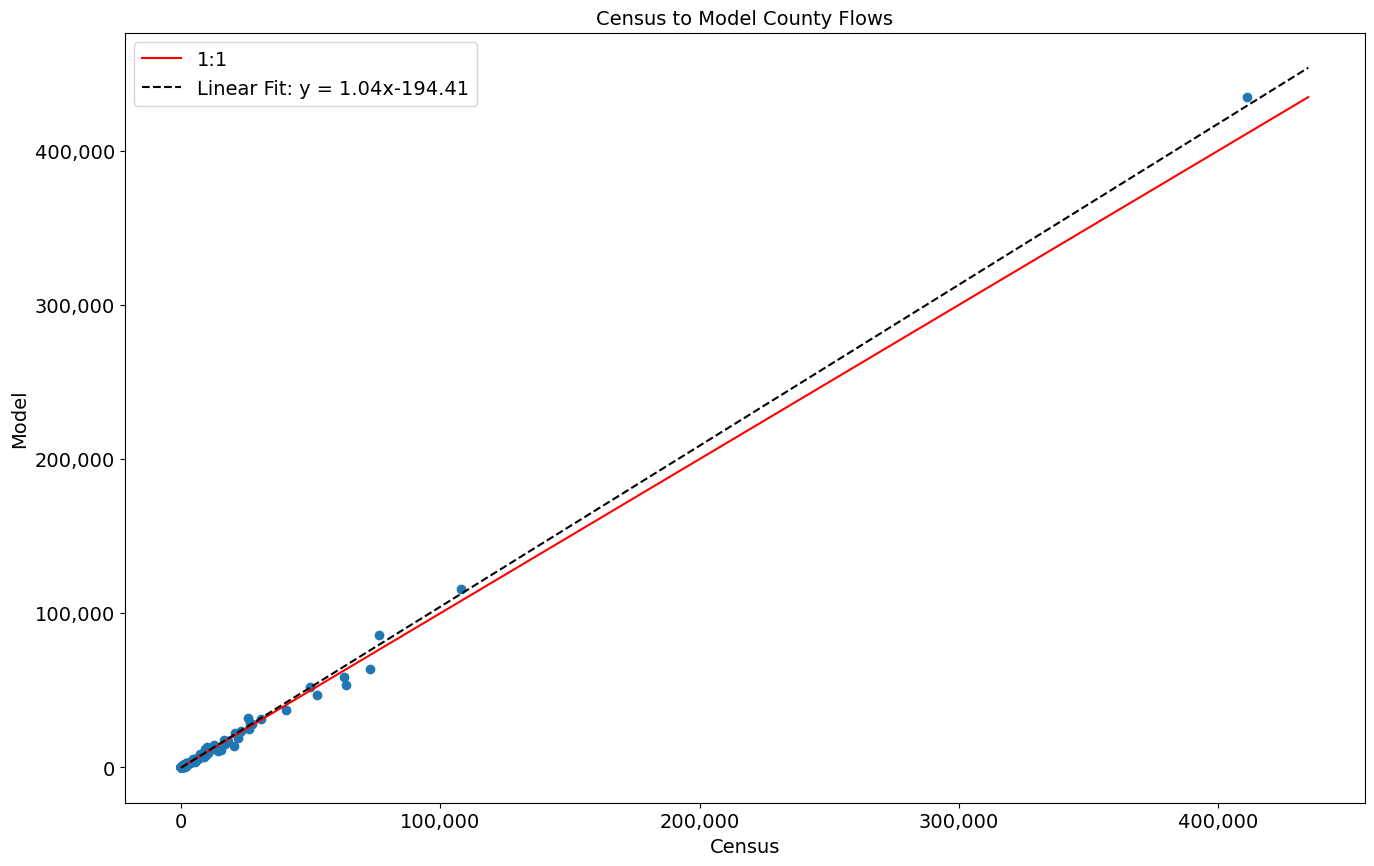

In [108]:
plot_data = model_co_flow.reset_index()[0:19].drop(columns = ['Total', 'home_state']).melt(id_vars = 'home_county', var_name = 'work_county', value_name = 'model').merge(
    census_co_flow.reset_index().rename(columns = {'O_County_Name': 'home_county'})[0:19].drop(columns = ['Total', 'home_state']).melt(id_vars = 'home_county', var_name = 'work_county', value_name = 'Census'),
    how = 'left', on = ['home_county', 'work_county']
)

x_pred = np.linspace(0, np.max(np.max(plot_data[['Census', 'model']])))
m,b = np.polyfit(plot_data.Census.fillna(0), plot_data.model.fillna(0), 1)

poly1d_fn = np.poly1d(np.polyfit(plot_data.Census.fillna(0), plot_data.model.fillna(0), 1)) 
print(f"Slope = {m}, intercept = {b}")

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot()
ax.scatter(plot_data.Census, plot_data.model)
sns.lineplot(x = x_pred, y = x_pred, ax=ax, color = 'red', label = '1:1')
sns.lineplot(x = x_pred, y = poly1d_fn(x_pred), ax = ax, color = 'black', linestyle='dashed', label = f'Linear Fit: y = {m:.2f}x{"+" if b >= 0 else ""}{b:.2f}')
plt.title("Census to Model County Flows", fontsize=14)
plt.legend(loc='upper left', fontsize=14)
ax.set_xlabel('Census', fontsize=14)
ax.set_ylabel('Model', fontsize=14)
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

c:\Users\andrew.rohne\.conda\envs\asim_asr_dev\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


Slope = 0.9926763321593198, intercept = -41.27180556444192


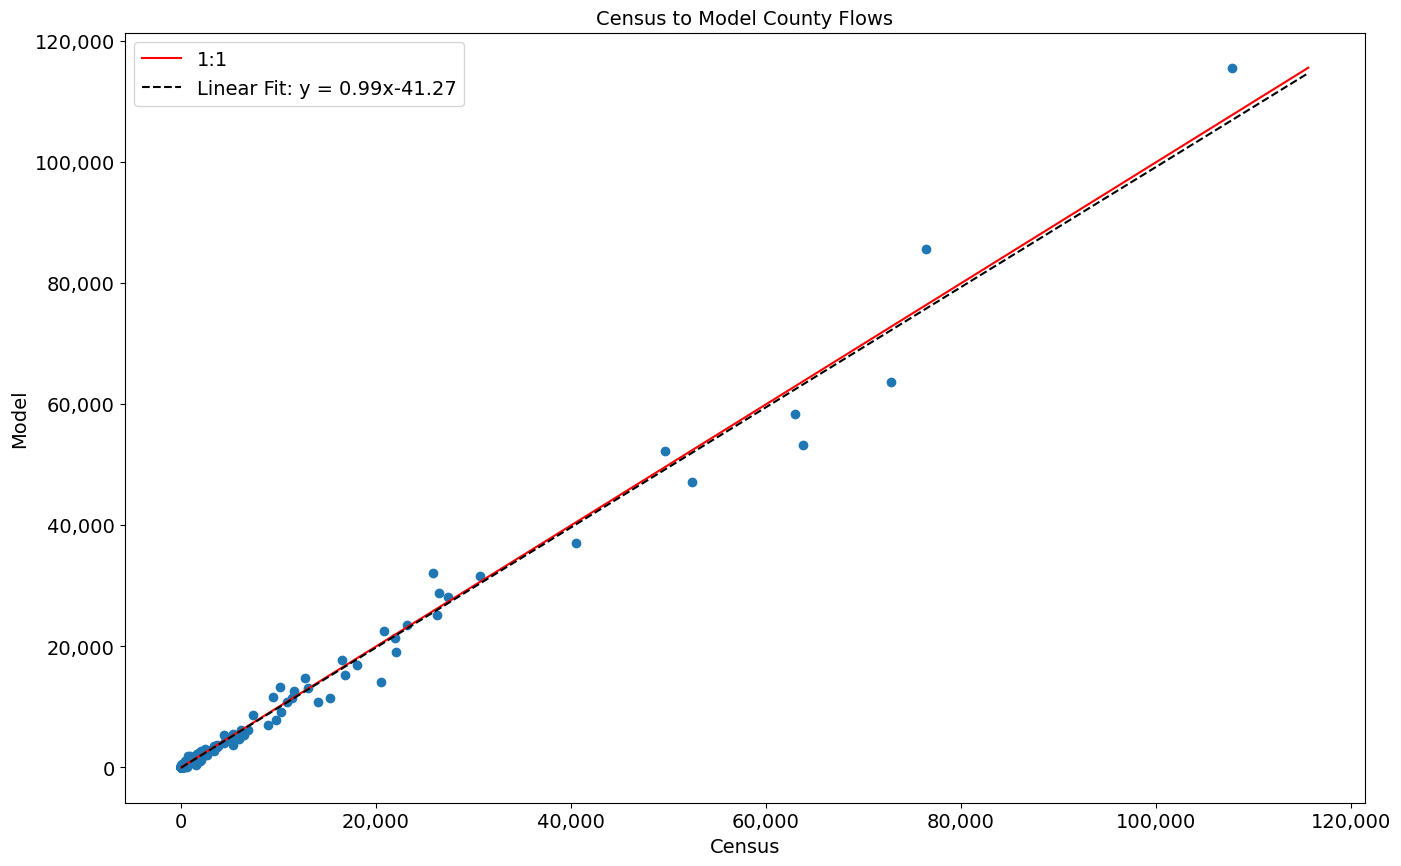

In [109]:
plot_data = model_co_flow.reset_index()[0:19].drop(columns = ['Total', 'home_state']).melt(id_vars = 'home_county', var_name = 'work_county', value_name = 'model').merge(
    census_co_flow.reset_index().rename(columns = {'O_County_Name': 'home_county'})[0:19].drop(columns = ['Total', 'home_state']).melt(id_vars = 'home_county', var_name = 'work_county', value_name = 'Census'),
    how = 'left', on = ['home_county', 'work_county']
)

plot_data = plot_data[plot_data['Census'] < 200000]

x_pred = np.linspace(0, np.max(np.max(plot_data[['Census', 'model']])))
m,b = np.polyfit(plot_data.Census.fillna(0), plot_data.model.fillna(0), 1)

poly1d_fn = np.poly1d(np.polyfit(plot_data.Census.fillna(0), plot_data.model.fillna(0), 1)) 
print(f"Slope = {m}, intercept = {b}")

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot()
ax.scatter(plot_data.Census, plot_data.model)
sns.lineplot(x = x_pred, y = x_pred, ax=ax, color = 'red', label = '1:1')
sns.lineplot(x = x_pred, y = poly1d_fn(x_pred), ax = ax, color = 'black', linestyle='dashed', label = f'Linear Fit: y = {m:.2f}x{"+" if b >= 0 else ""}{b:.2f}')
plt.title("Census to Model County Flows", fontsize=14)
plt.legend(loc='upper left', fontsize=14)
ax.set_xlabel('Census', fontsize=14)
ax.set_ylabel('Model', fontsize=14)
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [110]:
plot_data = model_co_flow.reset_index()[0:19].drop(columns = ['Total', 'home_state']).melt(id_vars = 'home_county', var_name = 'work_county', value_name = 'model').merge(
    census_co_flow.reset_index().rename(columns = {'O_County_Name': 'home_county'})[0:19].drop(columns = ['Total', 'home_state']).melt(id_vars = 'home_county', var_name = 'work_county', value_name = 'Census'),
    how = 'left', on = ['home_county', 'work_county']
)

# Comparisons:
# Mean Error (s/b 0)
# MAE
# Max abs error
# RMSE
mean_error = (plot_data['Census'] - plot_data['model']).mean()
mean_abs_error = (abs(plot_data['Census'] - plot_data['model'])).mean()
max_abs_error = (abs(plot_data['Census'] - plot_data['model'])).max()
rmse = ((plot_data['Census'] - plot_data['model'])**2).mean()**0.5
pct_rmse = rmse / plot_data['Census'].mean()
print(f"mean error: {mean_error:.02f}\nmean abs error: {mean_abs_error:.02f}\nmax abs error: {max_abs_error:,.02f}\npct RMSE: {pct_rmse:.2%}")


mean error: 0.00
mean abs error: 467.44
max abs error: 23,458.54
pct RMSE: 40.58%


# Adjust Trip Length

In [111]:
model_summary = persons[persons['is_out_of_home_worker']].groupby('distbin').agg(model = ('person_id', 'count')) * (survey_tlfd['Total'].sum() / persons[persons['is_out_of_home_worker']].shape[0])
adj_model = survey_tlfd[['distbin', 'Total']].copy().merge(model_summary, how = 'left', on = 'distbin')
adj_model['adjustment'] = np.log(adj_model['Total'] / adj_model['model'])


In [112]:
res1 = sm.OLS(endog = adj_model[adj_model['distbin'] < 11]['adjustment'], exog = adj_model[adj_model['distbin'] < 11]['distbin']).fit()
res1.summary()


c:\Users\andrew.rohne\.conda\envs\asim_asr_dev\lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             adjustment   R-squared (uncentered):                   0.229
Model:                            OLS   Adj. R-squared (uncentered):              0.143
Method:                 Least Squares   F-statistic:                              2.674
Date:                Wed, 10 Apr 2024   Prob (F-statistic):                       0.136
Time:                        10:23:46   Log-Likelihood:                          6.3620
No. Observations:                  10   AIC:                                     -10.72
Df Residuals:                       9   BIC:                                     -10.42
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
distbin       -0.0113      0.007     -1.635      0.136      -0.027       0.004
==============================================================================
Omnibus:                        2.026   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.363   Jarque-Bera (JB):                1.372
Skew:                           0.783   Prob(JB):                        0.504
Kurtosis:                       2.082   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""